# Unconstrained Multivariate Optimization

In [1]:
from scipy import optimize

import matplotlib.pyplot as plt
import numpy as np
import sympy

sympy.init_printing()

Multivariate optimization is significantly harder than the univariate optimization
discussed in the previous notebook. In particular, the analytical approach of solving
the nonlinear equations for roots of the gradient is rarely feasible in the multivariate
case, and the bracketing scheme used in the golden search method is also not directly
applicable. Instead we must resort to techniques that start at some point in the
coordinate space and use different strategies to move toward a better approximation
of the minimum point

The most basic approach of this type is to *consider the gradient* $\nabla{f(x)}$ of the objective function $f(x)$ at a given point $x$.

In general, the negative of the gradient, $−\nabla{f(x)}$, always points in the direction in which the function $f(x)$ decreases the most. As minimization strategy, it is therefore sensible to move along this direction for some distance $\alpha{k}$ and then iterate this scheme at the new point.

This method is known as the steepest descent method, and it gives

> **the iteration formula**: $x_{k+1} = x_k − \alpha_k \nabla f(x_k)$, where $\alpha k$ is a free parameter

known as the line search parameter that describes how far along
the given direction to move in each iteration. An appropriate $\alpha k$ can, for example, be
selected by solving

> **the one-dimensional optimization problem** $min_{ak}f(x_k - a_k \nabla f(x_k))$ .

This method is guaranteed to make progress and eventually converge to a minimum of the function, but the convergence can be quite slow because this method tends to overshoot along the direction of the gradient, giving a zigzag approach to the minimum. Nonetheless, the steepest descent method is the conceptual basis for many multivariate optimization algorithms, and with suitable modifications, the convergence can be speed up

#### Example 1:

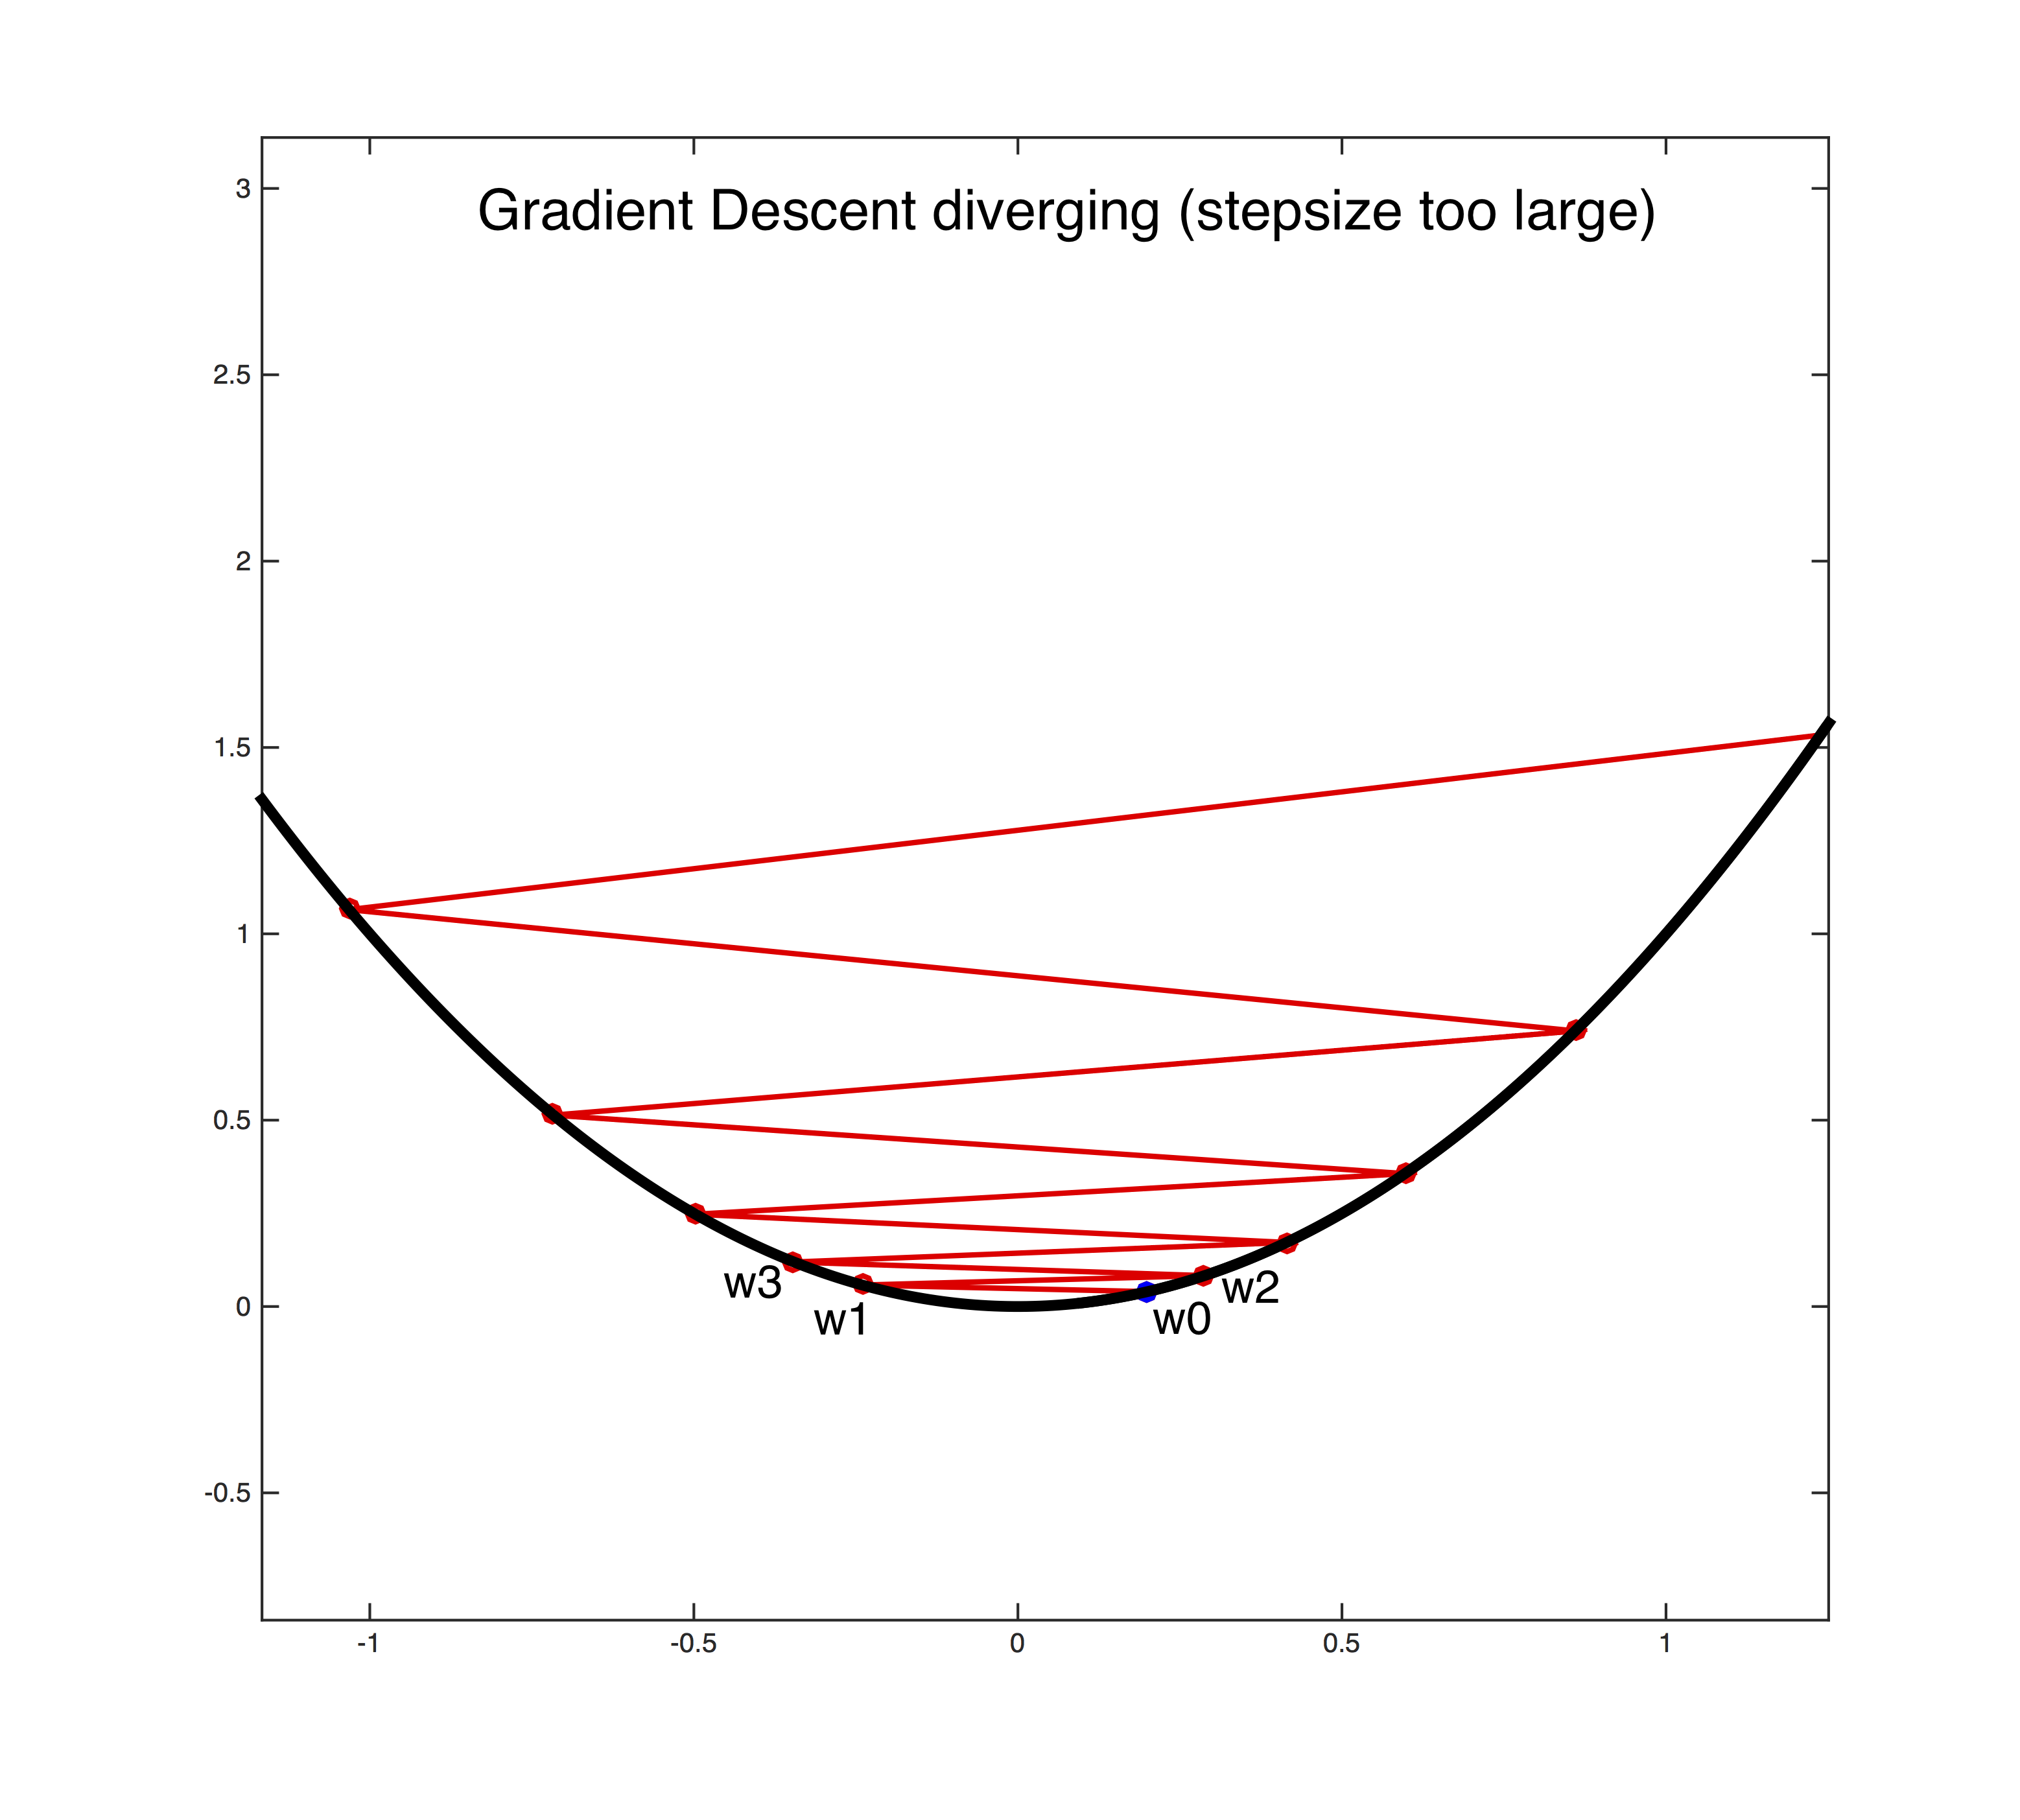

#### Example 2:

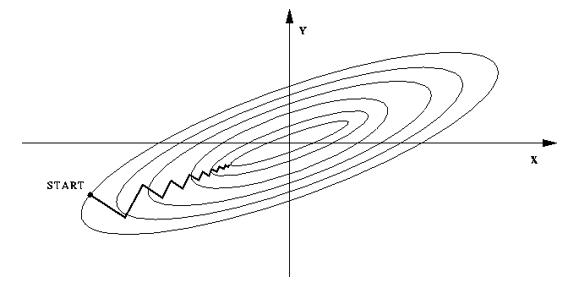

#### Example 3: troubles in 3d

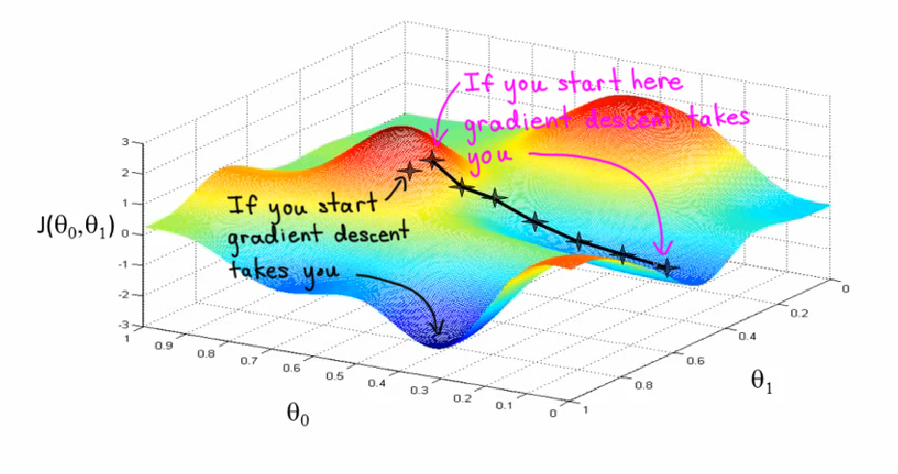

Newton's method for multivariate optimization is a modification of the steepest descent method that can improve convergence. *As in the univariate case, Newton's method can be viewed as a local quadratic approximation of the function*, which when minimized gives an iteration scheme.

> **In the multivariate case, the iteration formula**: $x_{k+1} = x_k-{H^{-1}_{f}}(x_k)\nabla f(x_k)$

#### Description: 

$x_{k+1}$ => next interation value

$x_k$ => initial value

${H^{-1}_{f}}(x_k)$ => Hessian Matrix for the function that we'll minimize at the point $x_k$

$-\nabla f(x_k)$ => Gradient of the function at the point $x_k$ is the steepest descend of the function

where compared to the steepest descent method, the gradient has been replaced with the gradient multiplied from the left with the inverse of Hessian matrix for the function

In general this alters both the direction and the
length of the step, so this method is not strictly a steepest descent method and may
not converge if started too far from a minimum. However, when close to a minimum, it
converges quickly

> As usual *there is a trade-off between convergence rate and stability.*
As it is formulated here, Newton’s method requires both the gradient and the Hessian of
the function.

In SciPy, *Newton’s method* is implemented in the function `optimize.fmin_ncg`. This
function takes the following arguments: a Python function for the objective function, a
starting point, a Python function for evaluating the gradient, and (optionally) a Python
function for evaluating the Hessian.

### Newton’s method Worked Example: 
To see how this method can be used to solve an optimization problem, we consider the following problem: $min_x f(x)$ where the objective function is $f(x) = (x_1 − 1)^4+5(x_2 − 1)^2 − 2x_1x_2$.

To apply Newton’s method, we need to calculate the gradient and the Hessian. For this particular case, this can easily be done by hand. However, for the sake of generality, in the following we use SymPy to
compute symbolic expressions for the gradient and the Hessian. To this end, we begin by defining symbols and a symbolic expression for the objective function, and then use the `sympy.diff` function for each variable to obtain the gradient and Hessian in symbolic form

In [2]:
x1, x2 = sympy.symbols("x_1, x_2")

# equation f(x)
f_x = (x1 - 1)**4 + 5 * (x2 - 1)**2 - 2*x1*x2

f_x

#### Gradient definition

$$
\nabla{f(x_1, x_2, \dots , x_n)}=
\begin{bmatrix}
  \frac{\partial{f(x_1, x_2, \dots , x_n)}}{\partial{x_1}} \\
  \frac{\partial{f(x_1, x_2, \dots , x_n)}}{\partial{x_2}} \\
  \vdots \\
  \frac{\partial{f(x_1, x_2, \dots , x_n)}}{\partial{x_n}}
 \end{bmatrix}
$$

In [3]:
# Gradient
f_x_grad = [f_x.diff(x_i) for x_i in (x1, x2)]
f_x_grad

In [4]:
# Wrap it by sympy.Matrix
f_x_grad = sympy.Matrix(f_x_grad)
f_x_grad

⎡                  3⎤
⎢-2⋅x₂ + 4⋅(x₁ - 1) ⎥
⎢                   ⎥
⎣-2⋅x₁ + 10⋅x₂ - 10 ⎦

#### Hessian Matrix

$$
H_f(x_1, x_2) = \begin{bmatrix}
  \frac{\partial{f(x_1, x_2)}}{\partial{x_1}} & \frac{\partial{f(x_1, x_2)}}{\partial{x_1 x_2}} \\
  \frac{\partial{f(x_1, x_2)}}{\partial{x_2 x_1}} & \frac{\partial{f(x_1, x_2)}}{\partial{x_2}}
 \end{bmatrix}
$$

In [6]:
# Hessian Matrix
f_x_hess = [[f_x.diff(x_i, x_j) for x_i in (x1, x2)] for x_j in (x1, x2)]
f_x_hess

In [ ]:
# Wrap it by sympy.Matrix
f_x_hess = sympy.Matrix(f_x_hess)
f_x_hess

> Now that we have a symbolic expression for the gradient and the Hessian, we can create vectorized functions for these expressions using `sympy.lambdify`

In [ ]:
f_x_lmbda = sympy.lambdify((x1, x2), f_x, 'numpy')
f_x_grad_lmbda = sympy.lambdify((x1, x2), f_x_grad, 'numpy')
f_x_hess_lmbda = sympy.lambdify((x1, x2), f_x_hess, 'numpy')

> However, the functions produced by `sympy.lambdify` take one argument for each variable in the corresponding expression, and the SciPy optimization functions expect a vectorized function where all coordinates are packed into one array. To obtain functions that are compatible with the SciPy optimization routines, we wrap each of the functions generated by `sympy.lambdify` with a Python function that rearranges the arguments

In [ ]:
# Just map signatures of the functions
def func_XY_to_X_Y(f):
    """
    Wrapper for f(x) -> f(x[0], x[1])
    """
    return lambda x: np.array(f(x[0], x[1]))

f = func_XY_to_X_Y(f_lmbda)
fprime = func_XY_to_X_Y(fprime_lmbda)
fhess = func_XY_to_X_Y(fhess_lmbda)

> Now the functions `f`, `fprime` and `fhess` are vectorized Python functions on the form that, for example, `optimize.fmin_ncg` expects, and we can proceed with a numerical optimization of the problem at hand by calling this function. In addition to the functions that we have prepared from SymPy expressions, we also need to give a starting point for the Newton method. Here we use (0, 0) as the starting point for the optimization

In [ ]:
# Optimize!
x_opt = optimize.fmin_ncg(f, (0, 0), fprime=fprime, fhess=fhess)
x_opt

> The routine found a minimum point at `(x1, x2) = (1.88292613, 1.37658523` and diagnostic information about the solution was also printed to standard output, including the number of iterations and the number of function, gradient, and Hessian evaluations that were required to arrive at the solution. As usual it is illustrative to visualize the objective function and the solution

In [ ]:
# Reminder of meshgrid

x = [-2, -1, 0, 1, 2]
y = [-3, -2, -1, 0, 1, 2, 3]
np.meshgrid(x, y)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

# Make a space for functions in diapason
x_ = y_ = np.linspace(-1, 4, 100)

X, Y = np.meshgrid(x_, y_)

c = ax.contour(X, Y, f_lmbda(X, Y), 50)

# Mark minimun
ax.plot(x_opt[0], x_opt[1], 'r*', markersize=15)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)

plt.colorbar(c, ax=ax)

> Contour plot of the objective function $f(x_1, x_2) = (x_1 − 1)4+5(x_2 − 1)2 − 2x_1x_2$. The minimum point is marked by a red star

> In practice, it may not always be possible to provide functions for evaluating both the gradient and the Hessian of the objective function, and often it is convenient with a solver that only requires function evaluations. For such cases, several methods exist to numerically estimate the gradient or the Hessian or both.

Methods that approximate the Hessian are known as **quasi-Newton methods**, and there are also alternative iterative methods that completely avoid using the Hessian. Two popular methods are the **Broyden-Fletcher-Goldfarb-Shanno (BFGS)** and the **conjugate gradient methods**, which are implemented in SciPy as the functions `optimize.fmin_bfgs` and `optimize.fmin_cg`

The BFGS method is a quasi-Newton method that can gradually build up numerical estimates of the Hessian, and also the gradient, if necessary.

The conjugate gradient method is a variant of the steepest descent method and does not use the Hessian, and it can be used with numerical estimates of the gradient obtained from only function evaluations. With these methods, the number of function evaluations that are required to solve a problem is much larger than for Newton’s method, which on the other hand also evaluates the gradient and the Hessian. Both `optimize.fmin_bfgs` and `optimize.fmin_cg` can optionally accept a function for evaluating the gradient, but if not provided, the gradient is estimated from function evaluations.

The preceding problem given, which was solved with the Newton method, can also be solved using the `optimize.fmin_bfgs` and `optimize.fmin_cg`, without providing a function for the Hessian

In [ ]:
x_opt = optimize.fmin_bfgs(f, (0, 0), fprime=fprime)
x_opt

In [ ]:
x_opt = optimize.fmin_cg(f, (0, 0), fprime=fprime)
x_opt

> As already mentioned, both of these methods can also be used without providing a function for the gradient as well, as shown in the following example using the `optimize.fmin_bfgs` solver

In [ ]:
x_opt = optimize.fmin_bfgs(f, (0, 0))
x_opt

> The methods for multivariate optimization that we have discussed so far all converge to a local minimum in general. For problems with many local minima, this can easily lead to a situation when the solver easily gets stuck in a local minimum, even if a global minimum exists. Although there is no complete and general solution to this problem, a practical approach that can partially alleviate this problem is to use a brute force search over a coordinate grid to find a suitable starting point for an iterative solver. At least this gives a systematic approach to find a global minimum within given coordinate ranges

In SciPy, the function `optimize.brute` can carry out such a systematic search. To illustrate this method, consider the problem of minimizing the function $4sin(x\pi)+ 6sin(y\pi)+(x − 1)^2+(y − 1)^2$, which has a large number of local minima.
This can make it tricky to pick a suitable initial point for an iterative solver. To solve this optimization problem with SciPy, we first define a Python function for the objective function

In [8]:
def f(X):
    x, y = X
    return (4 * np.sin(np.pi * x) + 6 * np.sin(np.pi * y)) + (x - 1)**2 + (y - 1)**2

To systematically search for the minimum over a coordinate grid, we call `optimize.brute` with the objective function $f$ as the first parameter and a tuple of slice objects as the second argument, one for each coordinate. The slice objects specify the coordinate grid over which to search for a minimum value. Here we also set the keyword argument `finish=None`, which prevents the `optimize.brute` from automatically refining the best candidate

In [10]:
f_x_argmin = optimize.brute(f,(slice(-3, 5, 0.5), slice(-3, 5, 0.5)), finish=None)
f_x_argmin

array([1.5, 1.5])

In [11]:
f(f_x_argmin)

On the coordinate grid specified by the given tuple of slice objects, the optimal point is `(x1, x2) = (1.5, 1.5)`, with corresponding objective function minimum −9.5. This is now a good starting point for a more sophisticated iterative solver, such as `optimize.fmin_bfgs`

In [13]:
x_opt = optimize.fmin_bfgs(f, x_start)
x_opt

Optimization terminated successfully.
         Current function value: -9.520229
         Iterations: 4
         Function evaluations: 21
         Gradient evaluations: 7


array([1.47586906, 1.48365787])

In [14]:
f(x_opt)

### Contour plot of the objective function $4sin(x\pi)+ 6sin(y\pi)+(x − 1)^2+(y − 1)^2$. The minimum is marked with a red star

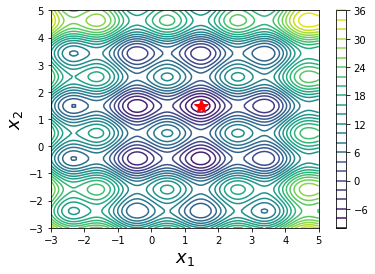

In [21]:
def func_X_Y_to_XY(f, X, Y):
    """
    Wrapper for f(X, Y) -> f([X, Y])
    """
    s = np.shape(X)
    # ravel return a contiguous flattened array
    return f(np.vstack([X.ravel(), Y.ravel()])).reshape(*s)

fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-3, 5, 100)
X, Y = np.meshgrid(x_, y_)

c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 25)

# Mark min
ax.plot(x_opt[0], x_opt[1], 'r*', markersize=15)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)

> SciPy also provides a unified interface for all multivariate optimization solver with the function `optimize.minimize`, which dispatches out to the solver-specific functions depending on the value of the method keyword argument (remember, the univariate minimization function that provides a unified interface is `optimize.scalar_minimize`)

In [22]:
x_opt = optimize.fmin_bfgs(f, x_start)
x_opt

Optimization terminated successfully.
         Current function value: -9.520229
         Iterations: 4
         Function evaluations: 21
         Gradient evaluations: 7


array([1.47586906, 1.48365787])

> For example, in the previous example, where we used `optimize.fmin_bfgs` in the following way

In [23]:
result = optimize.minimize(f, x_start, method= 'BFGS')
result

      fun: -9.520229273055016
 hess_inv: array([[2.41596001e-02, 4.61008275e-06],
       [4.61008275e-06, 1.63490348e-02]])
      jac: array([-7.15255737e-07, -7.15255737e-07])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([1.47586906, 1.48365787])